Load libraries

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import warnings
from tqdm import tqdm

PATH =  "/home/jmurga/mkt/201902"
import sys
sys.path.insert(0, PATH + '/scripts/src/')
from mktAnalysis import *

Load main data

In [2]:
dmelDataset  = pd.read_csv(PATH + "/results/dsimDmelSitesBinned.tsv",sep='\t')
humanDataset = pd.read_csv(PATH + "/results/afrEur.tsv",sep='\t')

In [3]:
%load_ext rpy2.ipython

In [4]:
def bEstimates(sfs,d,m,geneId,population,replica):

	# Execute each mkt test through Analytical.jl
	## StandardMKT
	dataset =  str(replica) + '_concat'

	checkDaf = sfs[sfs[:,0] > 0.25,:]
	if((np.sum(checkDaf[:,1]) == 0) | (np.sum(checkDaf[:,2]) == 0)):
		imp2 = {"alpha":np.nan,"pvalue":np.nan}
	else:
		imp2 = impMK(sfs=sfs,divergence=d,m=m,l=0.25);


	tmp = pd.DataFrame([dataset,population,imp2['alpha'],imp2['b'],imp2['f'],imp2['d']]).T
	tmp.columns= ["id","pop","alpha","b","f","d"]

	return(tmp)


# Recombination analysis

In [8]:
bins = np.arange(0,15)

## Zi

In [17]:
alphasZiRecomb = []
binnedZiRecomb = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(bins):
        a, b = sampleAnalysis(df = dmelDataset,population="ZI",sample=None,replicas=100,dofe=PATH + "/rawData/dofe/recomb",nthreads=7,recombBin=i,bins=bins.shape[0])
        alphasZiRecomb.append(a)
        binnedZiRecomb.append(b)
alphasZiRecomb = pd.concat(alphasZiRecomb)
binnedZiRecomb = pd.concat(binnedZiRecomb)

In [18]:
df = list()
for i in bins:
    tmp,tmp2,tmp3 = grapesOutput(PATH + "/rawData/dofe/recomb/zi/"+str(i)+"/","GammaZero","ZI",7)
    tmp['pop']  = 'ZI'
    tmp['bins'] = alphasZiRecomb.bins.unique()[i]
    tmp['pvalue'] = np.nan
    tmp = tmp.loc[:,['dataset','pop','alpha','pvalue','test','bins']]
    tmp.columns = ['id','pop','alpha','pvalue','test','bins']
    df.append(tmp)
grapesRecombZi = pd.concat(df)

In [19]:
df = pd.concat([alphasZiRecomb,grapesRecombZi])
df.bins = pd.Categorical(df.bins,categories = df.bins.unique())
df.test = pd.Categorical(df.test,categories = df.test.unique());
df

In [33]:
binnedZiRecomb

In [20]:
pkl.dump([df,binnedZiRecomb], open(PATH + "/results/recomb/ziRecomb.pkl", "wb" ))

## AFR

In [ ]:
alphasAfrRecomb = []
binnedAfrRecomb = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(bins):
        a, b = sampleAnalysis(df = humanDataset,population="AFR",sample=None,replicas=100,dofe=PATH + "/rawData/otherDofe/recomb",nthreads=7,recombBin=i,bins=bins.shape[0])
        alphasAfrRecomb.append(a)
        binnedAfrRecomb.append(b)
alphasAfrRecomb = pd.concat(alphasAfrRecomb)
binnedAfrRecomb = pd.concat(binnedAfrRecomb)

In [18]:
df = list()
for i in bins:
    tmp,tmp2,tmp3 = grapesOutput(PATH + "/rawData/dofe/recomb/afr/"+str(i)+"/","GammaZero","AFR",7)
    tmp['pop']  = 'AFR'
    tmp['bins'] = alphasAfrRecomb.bins.unique()[i]
    tmp['pvalue'] = np.nan
    tmp = tmp.loc[:,['dataset','pop','alpha','pvalue','test','bins']]
    tmp.columns = ['id','pop','alpha','pvalue','test','bins']
    df.append(tmp)
grapesRecombAfr = pd.concat(df)

In [19]:
df = pd.concat([alphasAfrRecomb,grapesRecombAfr])
df.bins = pd.Categorical(df.bins,categories = df.bins.unique())
df.test = pd.Categorical(df.test,categories = df.test.unique())

In [37]:
df = alphasAfrRecomb
df.bins = pd.Categorical(df.bins,categories = df.bins.unique())
df.test = pd.Categorical(df.test,categories = df.test.unique())

In [38]:
pkl.dump([df,binnedAfrRecomb], open(PATH + "/results/recomb/afrRecomb.pkl", "wb" ))

# Plots

Loading data from pickle and formating to plot in R

In [39]:
alphas, binned = loadPickleAlphas(PATH + "/results/recomb/*Recomb.pkl")

## ZI

In [7]:
alphasZiRecomb = alphas['ziRecomb.pkl']; binnedZiRecomb = binned['ziRecomb.pkl']

In [8]:
alphasZiRecomb.bins = pd.Categorical(alphasZiRecomb.bins,categories = alphasZiRecomb.bins.unique())
alphasZiRecomb.test = pd.Categorical(alphasZiRecomb.test,categories = alphasZiRecomb.test.unique())

In [9]:
alphasZiRecomb = alphasZiRecomb[(alphasZiRecomb.test != 'emkt1') & (alphasZiRecomb.test != 'fww1') & (alphasZiRecomb.test != 'imp1') & (alphasZiRecomb.test != 'asymp2')]

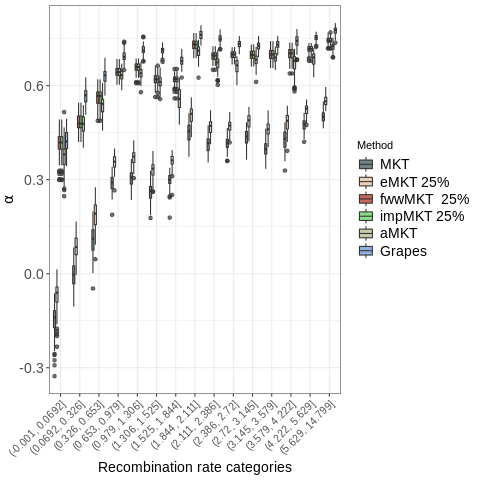

In [10]:
%%R -i alphasZiRecomb  -i PATH

df = as.data.table(alphasZiRecomb)

df = df[test != 'asymp2']

p = ggplot(df, aes(x = bins, y = value, fill =test)) + geom_boxplot( color = "grey20",alpha = 0.7) + theme_bw() + scale_x_discrete(name = "Recombination rate categories") +  scale_fill_manual(values=c("#30504f","#e2bd9a","#ab2710","#53cf53","#AEB782","#5C8FCE"),name="Method", labels = c("std" = "MKT", "emkt2" = "eMKT 25%", "fww1" = "fwwMKT 25%", "fww2" = "fwwMKT  25%", "imp2" = "impMKT 25%","asymp1" = "aMKT","grapes" = "Grapes")) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=10,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=14),axis.title=element_text(size=14),legend.position="right",legend.text=element_text(size=14)) + ylab(expression(alpha))

ggsave(p,filename = paste0(PATH,'/results/recomb/ziRecomb.svg'),dpi=600,width=10,height=7)
ggsave(p,filename = paste0(PATH,'/results/recomb/ziRecomb.png'),dpi=600,width=10,height=7)

p

In [23]:
df = dmelDataset

tmp = df[df['pop'] == 'ZI']
b = []
replicas = 100
population = 'ZI'

bins = np.arange(15)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(bins):

        sampling, grp = binByRecombRate(tmp,replicas,i,bins.shape[0])

        pool = Pool(processes = 7)
        lSfs,lDiv,lM,genes = zip(*pool.starmap(parseBinnedSfs,zip([df]*replicas,[population]*replicas,sampling)))
        pool.terminate()

        pool = Pool(processes = 7)
        tmpB = pool.starmap(bEstimates,zip(lSfs,lDiv,lM,genes,[population]*replicas,np.arange(1,replicas+1).tolist()))
        pool.terminate()
        tmpB = pd.concat(tmpB)
        tmpB['bins'] = grp
        b.append(tmpB)

    b = pd.concat(b)

100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


In [24]:
b.alpha = b.alpha.astype(float)
b.b     = b.b.astype(float)
b.f     = b.f.astype(float)
b.d     = b.d.astype(float)

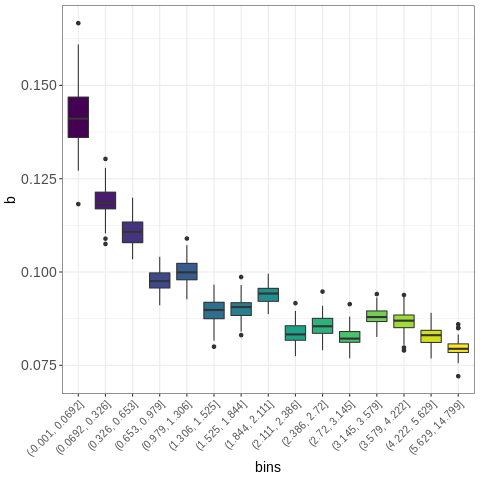

In [25]:
%%R -i b -i PATH

b = as.data.table(b)
b[['bins']] = as.factor(b[['bins']])

pB = ggplot(b,aes(x=bins,y=b,fill=bins))+ geom_boxplot(show.legend=F) + scale_fill_viridis_d() + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=10,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=14),axis.title=element_text(size=14),legend.position="right",legend.text=element_text(size=14))

ggsave(pB,filename = paste0(PATH,'/results/recomb/bZi.svg'),dpi=600,width=10,height=7)
ggsave(pB,filename = paste0(PATH,'/results/recomb/bZi.png'),dpi=600,width=10,height=7)

pB

## AFR

In [72]:
alphasAfrRecomb = alphas['afrRecomb.pkl']; binnedAfrRecomb = binned['afrRecomb.pkl']

In [73]:
alphasAfrRecomb.bins = pd.Categorical(alphasAfrRecomb.bins,categories = alphasAfrRecomb.bins.unique())
alphasAfrRecomb.test = pd.Categorical(alphasAfrRecomb.test,categories = alphasAfrRecomb.test.unique())

In [74]:
alphasAfrRecomb = alphasAfrRecomb[(alphasAfrRecomb.test != 'emkt1') & (alphasAfrRecomb.test != 'fww1') & (alphasAfrRecomb.test != 'imp1') & (alphasAfrRecomb.test != 'asymp2')]

In [75]:
alphasAfrRecomb.bins = alphasAfrRecomb.bins.apply(lambda r: float(r.split(',')[0].split('(')[1])).astype(float)

 [1] -0.000761  0.027500  0.048700  0.073000  0.099100  0.130000  0.170000
 [8]  0.218000  0.275000  0.346000  0.429000  0.540000  0.675000  0.843000
[15]  1.048000  1.314000  1.682000  2.209000  3.008000  4.676000


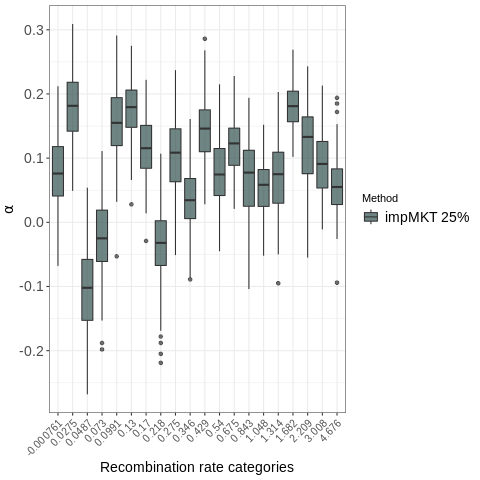

In [83]:
%%R -i alphasAfrRecomb  -i PATH

df = as.data.table(alphasAfrRecomb)

df = df[test == 'imp2']
print(df$bins %>% unique)
p = ggplot(df, aes(x = as.factor(bins), y = value, fill =test)) + geom_boxplot( color = "grey20",alpha = 0.7) + theme_bw() + scale_x_discrete(name = "Recombination rate categories") +  scale_fill_manual(values=c("#30504f","#e2bd9a","#ab2710","#53cf53","#AEB782","#5C8FCE"),name="Method", labels = c("std" = "MKT", "emkt2" = "eMKT 25%", "fww1" = "fwwMKT 25%", "fww2" = "fwwMKT  25%", "imp2" = "impMKT 25%","asymp1" = "aMKT","grapes" = "Grapes")) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=10,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=14),axis.title=element_text(size=14),legend.position="right",legend.text=element_text(size=14)) + ylab(expression(alpha))
#ggsave(p,filename = paste0(PATH,'/results/recomb/afrRecomb.svg'),dpi=600,width=10,height=7)
#ggsave(p,filename = paste0(PATH,'/results/recomb/afrRecomb.png'),dpi=600,width=10,height=7)

p


In [26]:
df = humanDataset

tmp = df[df['pop'] == 'AFR']
b = []
replicas = 100
population = 'AFR'

bins = np.arange(15)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(bins):

        sampling, grp = binByRecombRate(tmp,replicas,i,bins.shape[0])

        pool = Pool(processes = 7)
        lSfs,lDiv,lM,genes = zip(*pool.starmap(parseBinnedSfs,zip([df]*replicas,[population]*replicas,sampling)))
        pool.terminate()

        pool = Pool(processes = 7)
        tmpB = pool.starmap(bEstimates,zip(lSfs,lDiv,lM,genes,[population]*replicas,np.arange(1,replicas+1).tolist()))
        pool.terminate()
        tmpB = pd.concat(tmpB)
        tmpB['bins'] = grp
        b.append(tmpB)

    b = pd.concat(b)

100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


In [29]:
b.alpha = b.alpha.astype(float)
b.b     = b.b.astype(float)
b.f     = b.f.astype(float)
b.d     = b.d.astype(float)

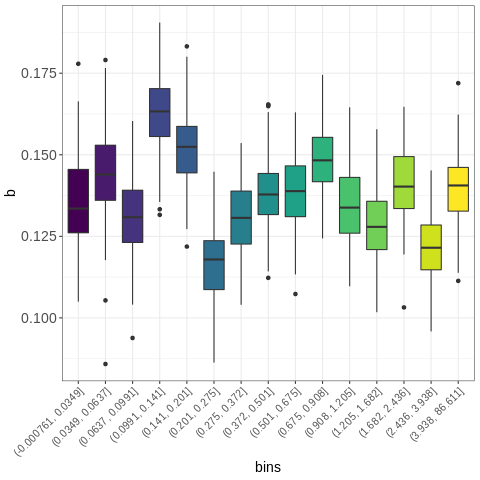

In [30]:
%%R -i b -i PATH

b = as.data.table(b)
b[['bins']] = as.factor(b[['bins']])

pB = ggplot(b,aes(x=bins,y=b,fill=bins))+ geom_boxplot(show.legend=F) + scale_fill_viridis_d() + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=10,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=14),axis.title=element_text(size=14),legend.position="right",legend.text=element_text(size=14))

ggsave(pB,filename = paste0(PATH,'/results/recomb/bAfr.svg'),dpi=600,width=10,height=7)
ggsave(pB,filename = paste0(PATH,'/results/recomb/bAfr.png'),dpi=600,width=10,height=7)

pB

# Tables

In [31]:
dfRecomb = pd.concat([alphasZiRecomb,alphasAfrRecomb])

In [32]:
tmpRecomb = dfRecomb.groupby(['test','pop','bins']).value.describe(percentiles=[0.05,0.5,0.95])[['mean','5%','95%']].reset_index()

In [33]:
tmpRecomb[['ci']] = np.round(tmpRecomb[['mean']],3).astype(str).values + ' (' + np.round(tmpRecomb[['5%']],3).astype(str).values + '-' + np.round(tmpRecomb[['95%']],3).astype(str).values +')'

In [37]:
recombPaper = pd.pivot_table(tmpRecomb[['test','pop','bins','ci']], values=['ci'], index=['pop','bins'],columns = 'test',aggfunc=lambda x: ' '.join(x));recombPaper

ci                          \
test                                        std                   emkt2   
pop bins                                                                  
AFR (-0.000761, 0.0349]  -0.501 (-0.591--0.433)   -0.459 (-0.552--0.39)   
    (0.0349, 0.0637]     -0.555 (-0.684--0.445)  -0.507 (-0.629--0.398)   
    (0.0637, 0.0991]     -0.637 (-0.725--0.564)  -0.591 (-0.673--0.519)   
    (0.0991, 0.141]       -0.53 (-0.638--0.432)  -0.472 (-0.576--0.378)   
    (0.141, 0.201]        -0.44 (-0.532--0.355)  -0.393 (-0.484--0.313)   
    (0.201, 0.275]        -0.593 (-0.69--0.502)  -0.552 (-0.649--0.469)   
    (0.275, 0.372]        -0.42 (-0.568--0.306)  -0.378 (-0.519--0.266)   
    (0.372, 0.501]        -0.46 (-0.546--0.379)    -0.414 (-0.5--0.338)   
    (0.501, 0.675]       -0.517 (-0.609--0.444)  -0.466 (-0.548--0.395)   
    (0.675, 0.908]       -0.502 (-0.581--0.427)  -0.447 (-0.528--0.373)   
    (0.908, 1.205]       -0.525 (-0.615--0.428)  -0.471 (-0.555--0.372)   
    (1.205, 1.682]       -0.484 (-0.543--0.429)  -0.435 (-0.499--0.377)   
    (1.682, 2.436]       -0.458 (-0.535--0.378)   -0.404 (-0.477--0.33)   
    (2.436, 3.938]        -0.385 (-0.528--0.27)   -0.34 (-0.475--0.233)   
    (3.938, 86.611]      -0.395 (-0.478--0.336)  -0.347 (-0.428--0.284)   
ZI  (-0.001, 0.0692]      -0.148 (-0.247--0.08)  -0.069 (-0.162--0.008)   
    (0.0692, 0.326]       -0.003 (-0.067-0.069)      0.085 (0.026-0.15)   
    (0.326, 0.653]          0.106 (0.029-0.173)     0.187 (0.116-0.247)   
    (0.653, 0.979]          0.288 (0.243-0.329)     0.355 (0.315-0.393)   
    (0.979, 1.306]          0.304 (0.263-0.347)      0.371 (0.332-0.41)   
    (1.306, 1.525]           0.26 (0.201-0.311)     0.332 (0.277-0.378)   
    (1.525, 1.844]           0.299 (0.267-0.33)       0.36 (0.329-0.39)   
    (1.844, 2.111]           0.45 (0.397-0.491)     0.506 (0.459-0.543)   
    (2.111, 2.386]          0.414 (0.373-0.453)      0.469 (0.43-0.506)   
    (2.386, 2.72]           0.416 (0.375-0.448)      0.47 (0.434-0.498)   
    (2.72, 3.145]           0.435 (0.386-0.474)     0.487 (0.441-0.524)   
    (3.145, 3.579]          0.398 (0.357-0.438)     0.461 (0.425-0.497)   
    (3.579, 4.222]          0.427 (0.369-0.478)     0.483 (0.429-0.528)   
    (4.222, 5.629]          0.474 (0.435-0.499)     0.522 (0.486-0.544)   
    (5.629, 14.799]         0.501 (0.477-0.526)     0.552 (0.531-0.575)   

                                                                       \
test                                      fww2                   imp2   
pop bins                                                                
AFR (-0.000761, 0.0349]   0.048 (-0.069-0.141)   0.048 (-0.069-0.141)   
    (0.0349, 0.0637]      0.091 (-0.022-0.211)   0.091 (-0.021-0.211)   
    (0.0637, 0.0991]      -0.022 (-0.121-0.07)   -0.022 (-0.121-0.07)   
    (0.0991, 0.141]        0.177 (0.087-0.264)    0.177 (0.087-0.264)   
    (0.141, 0.201]         0.202 (0.112-0.282)    0.202 (0.112-0.282)   
    (0.201, 0.275]       -0.074 (-0.196-0.054)  -0.074 (-0.196-0.054)   
    (0.275, 0.372]         0.099 (-0.006-0.19)    0.099 (-0.006-0.19)   
    (0.372, 0.501]         0.082 (-0.005-0.18)    0.082 (-0.005-0.18)   
    (0.501, 0.675]        0.069 (-0.024-0.141)   0.069 (-0.024-0.141)   
    (0.675, 0.908]            0.12 (0.043-0.2)       0.12 (0.043-0.2)   
    (0.908, 1.205]        0.067 (-0.014-0.152)   0.067 (-0.014-0.152)   
    (1.205, 1.682]         0.06 (-0.016-0.151)    0.06 (-0.016-0.151)   
    (1.682, 2.436]         0.144 (0.083-0.205)    0.144 (0.083-0.206)   
    (2.436, 3.938]        0.104 (-0.021-0.202)   0.104 (-0.021-0.202)   
    (3.938, 86.611]        0.104 (0.028-0.178)    0.104 (0.028-0.177)   
ZI  (-0.001, 0.0692]       0.413 (0.345-0.469)    0.413 (0.345-0.469)   
    (0.0692, 0.326]        0.481 (0.429-0.524)    0.481 (0.429-0.524)   
    (0.326, 0.653]         0.562 (0.517-0.604)    0.562 (0.517-0.603)   
    (0.653, 0.979]         0.643 (0.

In [38]:
recombPaper.to_csv(PATH + '/results/recomb/recomb.tsv',sep='\t')